In [1]:
##imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import plotly.express as px

from pydataset import data
from scipy import stats
import statistics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix,recall_score,precision_score,accuracy_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.feature_selection import RFE, SelectKBest, f_regression

import env

import warnings
warnings.filterwarnings("ignore")


In [2]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'

df = pd.read_sql('SELECT * FROM logs', url)
df.head()
df0=df.copy()

In [3]:
df

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
900218,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33
900219,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33
900220,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33
900221,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86


In [4]:
df = df0.copy()
df.date = pd.to_datetime(df.date)
df = df.set_index("date")
df


,time,path,user_id,cohort_id,ip
date,,,,,
2018-01-26,09:55:03,/,1,8.0,97.105.19.61
2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...
2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33
2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33
2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33


In [5]:
pages = df['path'].resample('d').count()
pages.head()


date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: path, dtype: int64

SMA time series are much less noisy than the time series of the original data points. The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units.

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

In [6]:
#exponential moving average
ema_7d = pages.ewm(span=7).mean()
ema_7d
# 14 days EMA
ema_14d = pages.ewm(span=14).mean()
ema_14d.head()
# 30 days EMA
ema_30d = pages.ewm(span=30).mean()
ema_30d.head()
# 90 days EMA
ema_90d = pages.ewm(span=90).mean()
ema_90d.head()


date
2018-01-26    572.000000
2018-01-27    399.100000
2018-01-28    321.030081
2018-01-29    452.545042
2018-01-30    494.228442
Freq: D, Name: path, dtype: float64

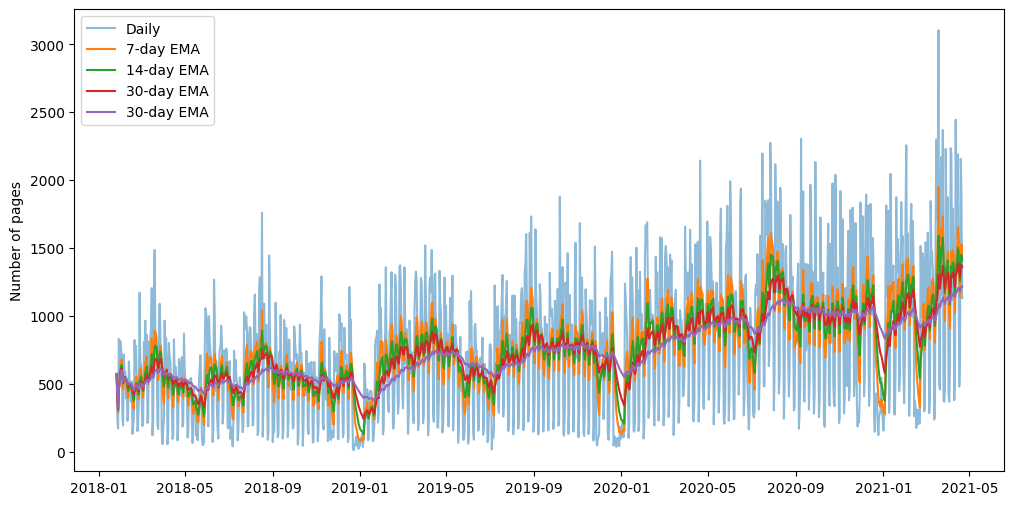

In [7]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [8]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()
midband.head()

# compute exponential stdev
stdev = pages.ewm(span=span).std()
stdev.head()

# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3
ub

# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()




,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,1120.791557,-330.191557
2018-01-28,956.773991,-326.494835
2018-01-29,1406.405897,-492.401124
2018-01-30,1354.808245,-352.070116


In [9]:
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()


,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


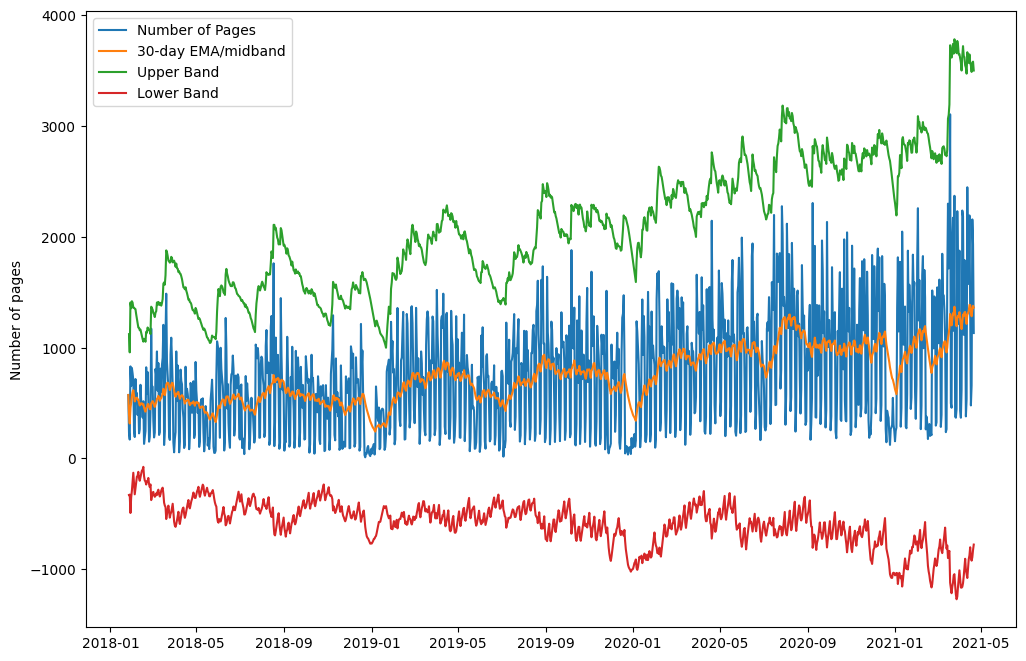

In [10]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()


In [11]:
# get the last measure of gb
last_measure = my_df.iloc[-1].pages
last_measure


1131.0

In [12]:
# get the lower band value on the last date
last_lb = my_df.iloc[-1].lb
last_lb


-777.340451135389

In [13]:
# get the upper band value on the last date
last_ub = my_df.iloc[-1].ub
last_ub


3499.0943598250406

In [14]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))


%b for last datapoint:  0.45


In [15]:
my_df.tail(3)


,pages,midband,ub,lb
date,,,,
2021-04-19,2156,1338.574023,3569.147958,-891.999913
2021-04-20,1930,1376.730537,3579.231798,-825.770723
2021-04-21,1131,1360.876954,3499.094360,-777.340451


In [16]:
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head()


,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


In [17]:
my_df[my_df['pct_b']>1]


,pages,midband,ub,lb,pct_b
date,,,,,


In [24]:
def acquire(file_name, column_names):
    ''' 
    acquires a file i don't have
    '''
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    ''' 
    preps a specific dataframe with basic info for processing
    '''
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['path'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    ''' 
    input series, span for weighted average, weight for std-dev, and user to investigate
    sets a midband and shifts it by standard dev * weight
    creates a new dataframe on the page count and bands, with the feature of percent_b (pct_b) for user

    '''
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    ''' 
    prints out the returned dataframe from compute_pct_b
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

def find_anomalies(df, user, span, weight):
    ''' 
    
    '''
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b>1]


In [21]:
#file_name = "anonymized-curriculum-access.txt"
#column_names = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']
#df = acquire(file_name, column_names)
#df.head()
df=df0.copy()


In [23]:
df

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
900218,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33
900219,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33
900220,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33
900221,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86


In [27]:
user = 1
span = 30
weight = 3
user_df = find_anomalies(df, user, span, weight)

anomalies = pd.DataFrame()
user_df = find_anomalies(df, user, span, weight)
anomalies = pd.concat([anomalies, user_df], axis=0)
anomalies


,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2018-02-20,54,6.456745,50.349000,-37.435509,1.041590,1
2018-05-29,68,9.612443,62.374629,-43.149742,1.053309,1
2018-11-07,13,1.221442,11.524503,-9.081619,1.071605,1
2018-12-19,25,2.880262,22.002760,-16.242235,1.078369,1
2019-01-29,44,3.623334,36.587343,-29.340675,1.112436,1
2019-07-08,101,8.248768,83.899086,-67.401549,1.113026,1
2020-01-15,41,6.259332,39.731193,-27.212529,1.018953,1
2021-01-05,40,4.050795,35.348264,-27.246673,1.074315,1
2021-04-15,52,9.075259,50.177299,-32.026781,1.022173,1


In [29]:
span = 30
weight = 3.5

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)
anomalies

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-01-29,44,3.623334,42.081344,-34.834677,1.024945,1
2019-07-08,101,8.248768,96.507472,-80.009936,1.025451,1
2018-10-15,9,0.581421,8.457414,-7.294571,1.034446,3
2019-01-09,4,0.262470,3.802115,-3.277175,1.027953,3
2019-04-06,2,0.129825,1.889712,-1.630061,1.031334,3
...,...,...,...,...,...,...
2021-01-24,7,0.574393,6.857226,-5.708440,1.011362,817
2021-03-25,59,6.824556,58.415342,-44.766230,1.005666,843
2021-02-23,67,8.229409,66.322904,-49.864086,1.005828,851


In [30]:
anomalies.pages.value_counts(sort=False)


44      4
101     2
9      42
4      76
2      36
38      4
74      4
17     22
5      58
6      53
27     13
12     29
15     22
8      52
13     33
34     13
7      48
1      48
3      71
29      7
25     11
23     12
24     14
16     29
11     34
10     34
32     12
31      2
55      2
28     12
21     15
18     23
57      2
22     11
72      2
20     18
33      9
19     22
59      3
26      9
46      3
14     21
73      2
60      1
36      8
47      2
30     11
65      1
89      1
43      4
41      5
42      4
35      4
40      7
107     1
198     1
96      1
48      3
78      4
52      4
62      3
54      3
153     1
37      5
95      2
104     1
45      4
67      3
84      1
49      1
61      1
129     1
94      1
272     1
109     1
108     1
76      1
53      3
117     1
82      1
81      1
128     1
64      1
116     1
165     1
192     1
58      4
66      1
93      1
39      1
56      1
146     1
75      1
113     1
69      1
179     1
99      1
50      2
122     1
Name: page

In [31]:
anomalies[anomalies.pages==272]


,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341


In [32]:
anomalies[anomalies.user_id==341]


,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341
2020-02-18,3,0.193548,2.817185,-2.430088,1.034840,341
2020-04-21,109,7.250725,102.413277,-87.911826,1.034608,341
2021-02-09,10,0.659630,9.508602,-8.189342,1.027766,341


In [33]:
df[df.user_id==341]


,date,time,path,user_id,cohort_id,ip
181808,2019-01-22,15:23:24,/,341,29.0,97.105.19.58
181826,2019-01-22,15:25:51,toc,341,29.0,97.105.19.58
181840,2019-01-22,15:26:44,html-css,341,29.0,97.105.19.58
181862,2019-01-22,15:28:33,html-css/introduction,341,29.0,97.105.19.58
181870,2019-01-22,15:29:29,html-css/elements,341,29.0,97.105.19.58
...,...,...,...,...,...,...
817183,2021-02-09,21:02:55,search/search_index.json,341,29.0,172.124.70.146
817184,2021-02-09,21:03:20,appendix/further-reading/spring/seeder,341,29.0,172.124.70.146
817268,2021-02-10,08:31:18,appendix/code-standards/mysql,341,29.0,172.124.70.146
817269,2021-02-10,08:31:29,appendix/further-reading/spring/pagination,341,29.0,172.124.70.146
